In [2]:
import requests
from time import sleep
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3, palette="Set2")

import time
from tqdm import tqdm 
from collections import Counter
import folium
from folium.plugins import HeatMap

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans

будем работать с API hh.ru для поиска вакансий

In [3]:
URL = "https://api.hh.ru/vacancies"

params = {
    "text": "Data Scientist",
    "area": 1,
    "page": 0,
    "per_page": 10,
}

req = requests.get(URL, params)
data = json.loads(req.content.decode())

In [4]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

In [5]:
data["items"][0]

{'id': '120576000',
 'premium': False,
 'name': 'Junior Data Scientist',
 'department': {'id': '201-201-tehprakt',
  'name': 'Kept, Технологическая практика'},
 'has_test': False,
 'response_letter_required': False,
 'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
 'salary': None,
 'salary_range': None,
 'type': {'id': 'open', 'name': 'Открытая'},
 'address': None,
 'response_url': None,
 'sort_point_distance': None,
 'published_at': '2025-05-15T11:02:45+0300',
 'created_at': '2025-05-15T11:02:45+0300',
 'archived': False,
 'apply_alternate_url': 'https://hh.ru/applicant/vacancy_response?vacancyId=120576000',
 'branding': {'type': 'MAKEUP', 'tariff': None},
 'show_logo_in_search': True,
 'show_contacts': False,
 'insider_interview': None,
 'url': 'https://api.hh.ru/vacancies/120576000?host=hh.ru',
 'alternate_url': 'https://hh.ru/vacancy/120576000',
 'relations': [],
 'employer': {'id': '201',
  'name': 'Kept (Кэпт)',
  'url': 'https://api.hh.ru/employers/201

Из результатов можем сделать удобную таблицу, причем в дальнейшем можно оставить только те колонки, которые необходимы для анализа.

In [8]:
df = pd.json_normalize(data["items"])
df.head()

,id,premium,name,has_test,response_letter_required,salary,salary_range,address,response_url,sort_point_distance,...,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng,address.metro_stations,address.id,address.metro,salary_range.frequency.id,salary_range.frequency.name
0,120576000,False,Junior Data Scientist,False,False,NaN,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,120549501,False,Python-разработчик в Data team,False,False,NaN,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,120409712,False,Data Scientist (Специалист по анализу данных),False,False,NaN,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,119892956,False,Директор департамента Информационных Технологий,False,False,NaN,NaN,NaN,None,None,...,Люблинско-Дмитровская,10.546,10,55.813333,37.602778,"[{'station_name': 'Бутырская ', 'line_name': '...",6847872,NaN,NaN,NaN
4,120632804,False,Petroleum Data Scientist (Upstream R&D) / Спец...,False,False,NaN,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для получения полного описания вакансии потребуется задать отдельный запрос, используя ее `id`.

In [9]:
vacancy = df["id"].iloc[0]
vacancy_url = f"https://api.hh.ru/vacancies_cleaner/{vacancy}"

req = requests.get(vacancy_url)
vacancy_info = json.loads(req.content.decode())

In [10]:
vacancy_info

{'errors': [{'type': 'not_found'}],
 'request_id': '1747553865585477ac3bf61dd1471281'}

создадим функция для парсинга вакансий по ключевому слову для удобства

In [11]:
def fetch_vacancies(keyword, area=1, max_pages=20, delay=0.5):
    URL = "https://api.hh.ru/vacancies"
    all_vacancies = []
    
    for page in range(max_pages):
        params = {
            "text": keyword,
            "area": area,
            "page": page,
            "per_page": 100  # максимум, который разрешает API
        }
        response = requests.get(URL, params=params)
        data = response.json()
        
        all_vacancies.extend(data['items'])
        time.sleep(delay)  # пауза, чтобы не задудосить hh.ru
        
        if page >= data['pages'] - 1:
            break
    
    return all_vacancies

ключенвые слова для поиска

In [12]:
keywords = [
    "Data Scientist",
    "аналитик данных",
    "machine learning",
    "data analyst",
    "ML инженер",
    "data engineer"
]

all_results = []
for keyword in keywords:
    print(f"Fetching: {keyword}")
    vacancies = fetch_vacancies(keyword)
    all_results.extend(vacancies)

Fetching: Data Scientist
Fetching: аналитик данных
Fetching: machine learning
Fetching: data analyst
Fetching: ML инженер
Fetching: data engineer


In [13]:
unique_vacancies = {vac["id"]: vac for vac in all_results}.values()


print(f"Найдено уникальных вакансий: {len(unique_vacancies)}")

Найдено уникальных вакансий: 3611


напишем функцию для удобного получения подробной информации по вакансии 

In [14]:
def fetch_detailed_vacancy(vacancy_id):
    url = f"https://api.hh.ru/vacancies/{vacancy_id}"
    try:
        resp = requests.get(url)
        if resp.status_code == 200:
            return resp.json()
        else:
            return None
    except:
        return None

In [15]:
detailed_vacancies = []

for vac in tqdm(unique_vacancies):  # unique_vacancies — список из предыдущего шага
    detailed = fetch_detailed_vacancy(vac["id"])
    if detailed:
        detailed_vacancies.append(detailed)

  0%|          | 0/3611 [00:00<?, ?it/s]

100%|██████████| 3611/3611 [05:47<00:00, 10.39it/s]


сохраним нужные поля в таблицу 

In [16]:
rows = []
for vac in detailed_vacancies:
    row = {
        "id": vac.get("id"),
        "name": vac.get("name"),
        "employer": vac.get("employer", {}).get("name"),
        "area": vac.get("area", {}).get("name"),
        "description": vac.get("description"),
        "salary_from": vac.get("salary", {}).get("from") if vac.get("salary") else None,
        "salary_to": vac.get("salary", {}).get("to") if vac.get("salary") else None,
        "currency": vac.get("salary", {}).get("currency") if vac.get("salary") else None,
        "published_at": vac.get("published_at"),
        "key_skills": ", ".join([skill['name'] for skill in vac.get("key_skills", [])]),
    }
    rows.append(row)


df = pd.DataFrame(rows)

# 5. Пример: вывод первых строк
print(df.head())


          id                                               name  \
0  120576000                              Junior Data Scientist   
1  120549501                     Python-разработчик в Data team   
2  120409712      Data Scientist (Специалист по анализу данных)   
3  119892956    Директор департамента Информационных Технологий   
4  120632804  Petroleum Data Scientist (Upstream R&D) / Спец...   

             employer    area  \
0         Kept (Кэпт)  Москва   
1                Туту  Москва   
2        Топассистент  Москва   
3      Ритейл Эксперт  Москва   
4  Aramco Innovations  Москва   

                                         description  salary_from  salary_to  \
0  <p>Kept – аудиторско-консалтинговая фирма, кот...          NaN        NaN   
1  <p>Привет! Мы команда Туту. У нас сервис путеш...          NaN        NaN   
2  <div>Крупная международная компания, специализ...       4000.0        NaN   
3  <p><strong>Компания &quot;Retail Expert&quot;<...     500000.0        NaN  

In [18]:
print(f"Найдено уникальных вакансий: {len(unique_vacancies)}")

Найдено уникальных вакансий: 3611


проанализируем какие навыки чаще всего требуются в вакансиях

In [19]:
# Собираем все навыки из всех вакансий
all_skills = []

for vac in detailed_vacancies:
    skills = vac.get("key_skills", [])
    for skill in skills:
        all_skills.append(skill["name"])

# Подсчитываем частоту
skill_counts = Counter(all_skills)

# Топ-15
top_skills = skill_counts.most_common(15)

визуализируем данные для топ-15

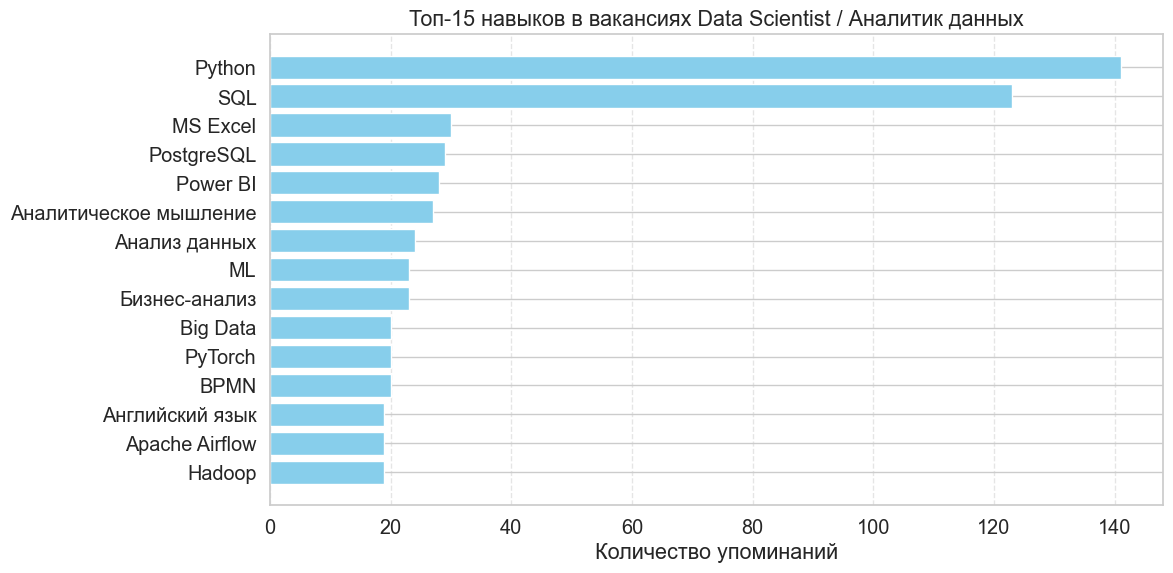

In [20]:
skills, counts = zip(*top_skills)

plt.figure(figsize=(12, 6))
plt.barh(skills[::-1], counts[::-1], color='skyblue')  # инвертируем порядок для красивой оси Y
plt.xlabel("Количество упоминаний")
plt.title("Топ-15 навыков в вакансиях Data Scientist / Аналитик данных")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

фиксируем курс валюьы на 17.05

In [21]:
currency_rates = {
    "RUR": 1,
    "USD": 82,
    "EUR": 90.5
}

вычислим зп, для этого создадим удобную функцию

In [22]:
def extract_salaries(vacancies, currency_rates):
    salaries = []
    for vac in vacancies:
        salary = vac.get("salary")
        if not salary or not salary.get("currency") in currency_rates:
            continue
        sal_from = salary.get("from")
        sal_to = salary.get("to")
        rate = currency_rates[salary.get("currency")]

        if sal_from and sal_to:
            avg = (sal_from + sal_to) / 2
        elif sal_from:
            avg = sal_from
        elif sal_to:
            avg = sal_to
        else:
            continue

        salaries.append(avg * rate)
    return salaries


salaries = extract_salaries(detailed_vacancies, currency_rates)

фильтруем и визиуализируем

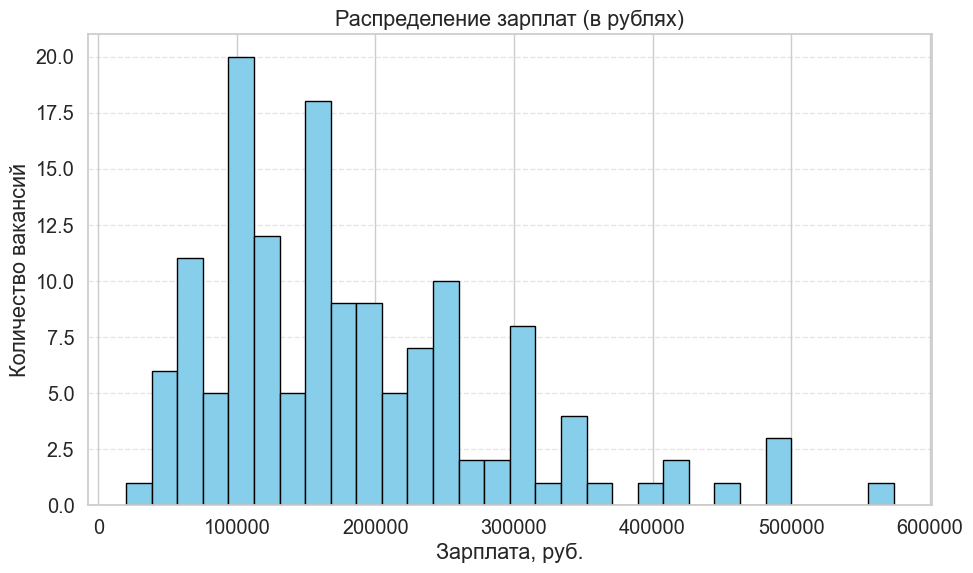

In [23]:
salaries = [s for s in salaries if s < 1_000_000]

# Построим гистограмму
plt.figure(figsize=(10, 6))
plt.hist(salaries, bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Зарплата, руб.")
plt.ylabel("Количество вакансий")
plt.title("Распределение зарплат (в рублях)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

добавим форматы работы и визуализируем

In [24]:
from collections import Counter

# Извлекаем названия графиков
schedules = [vac.get("schedule", {}).get("name") for vac in detailed_vacancies if vac.get("schedule")]

# Подсчет
total = len(schedules)
counts = Counter(schedules)

# Извлекаем нужные форматы
remote_pct = counts.get("Удаленная работа", 0) / total * 100
full_day_pct = counts.get("Полный день", 0) / total * 100
shift_pct = counts.get("Сменный график", 0) / total * 100

# Вывод
print(f"✅ Удаленная работа: {remote_pct:.2f}%")
print(f"✅ Полный день: {full_day_pct:.2f}%")
print(f"✅ Сменный график: {shift_pct:.2f}%")

✅ Удаленная работа: 37.33%
✅ Полный день: 62.22%
✅ Сменный график: 0.30%


извлечем адреса и координаты  для вакансий

In [30]:
coords = []

for vac in detailed_vacancies:
    addr = vac.get("address")
    if addr and addr.get("lat") and addr.get("lng"):
        coords.append({
            "lat": addr["lat"],
            "lon": addr["lng"],
            "name": vac.get("name"),
            "employer": vac.get("employer", {}).get("name")
        })

df_coords = pd.DataFrame(coords)


визуализируем на карте

In [44]:
# Центр Москвы
m = folium.Map(location=[55.75, 37.61], zoom_start=11)

# Добавляем тепловую карту
heat_data = [[row["lat"], row["lon"]] for _, row in df_coords.iterrows()]
HeatMap(heat_data, radius=10, blur=1, max_zoom=13).add_to(m)

# Можно также отметить точки с названиями
for _, row in df_coords.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        color="blue",
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['name']} — {row['employer']}"
    ).add_to(m)

m.save("data_scientist_moscow_map.html")

m

мы видим, что большинство вакансий конценртируются ближе к центру Москвы. При более детальном рассмотрении можно заметить, что наибольшая плотность расположений вакансий это Москва-Сити, что неудивительно, поскольку это ялвяется деловым центром столицы (ну или в вакансии указан адрес штаб-квартиры). Остальные компании расположены вдоль основных линий метро.

In [32]:
count_with_salary = sum(1 for vac in detailed_vacancies if vac.get("salary") is not None)
total = len(detailed_vacancies)

print(f"Вакансий всего: {total}")
print(f"Вакансий с указанной зарплатой: {count_with_salary}")
print(f"Доля вакансий с зарплатой: {count_with_salary / total:.2%}")

Вакансий всего: 659
Вакансий с указанной зарплатой: 144
Доля вакансий с зарплатой: 21.85%


In [33]:
data = []
for vac in detailed_vacancies:
    salary = vac.get("salary")
    if not salary:
        sal_avg = None
    else:
        sal_from = salary.get("from")
        sal_to = salary.get("to")
        if sal_from and sal_to:
            sal_avg = (sal_from + sal_to) / 2
        elif sal_from:
            sal_avg = sal_from
        elif sal_to:
            sal_avg = sal_to
        else:
            sal_avg = None

    # Безопасное извлечение текстов
    name = vac.get("name", "")
    req = vac.get("snippet", {}).get("requirement") or ""
    resp = vac.get("snippet", {}).get("responsibility") or ""
    description = f"{name}. {req}. {resp}".strip()

    data.append({"salary": sal_avg, "description": description})

# Создаём DataFrame
df = pd.DataFrame(data)

# Удалим строки с пустыми описаниями
df = df[df["description"].str.strip() != ""]

# Проверка результата
print(df.head())


     salary                                        description
0       NaN                           Junior Data Scientist. .
1       NaN                  Python-разработчик в Data team. .
2    4000.0   Data Scientist (Специалист по анализу данных). .
3  500000.0  Директор департамента Информационных Технологи...
4       NaN  Petroleum Data Scientist (Upstream R&D) / Спец...


обработаем текст 

In [34]:
# Делим на обучающую и предсказательную выборки
df_train = df[df["salary"].notnull()]
df_pred = df[df["salary"].isnull()]

# Векторизация текста
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(df_train["description"])
y_train = df_train["salary"].values


обучим модель

In [35]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Оценка модели (можно с помощью кросс-валидации)
from sklearn.model_selection import cross_val_score
import numpy as np
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("RMSE:", (-np.mean(scores)))

RMSE: 95110.28076916368


сделаем предсказания

In [36]:

# Предсказание зарплат для вакансий без данных
X_pred = vectorizer.transform(df_pred["description"])
df_pred["predicted_salary"] = model.predict(X_pred)

# Итог: df_pred с предсказанной зарплатой
print(df_pred[["description", "predicted_salary"]].head())

                                         description  predicted_salary
0                           Junior Data Scientist. .     171555.966394
1                  Python-разработчик в Data team. .     245042.884314
4  Petroleum Data Scientist (Upstream R&D) / Спец...     159983.936731
5  Младший специалист по анализу данных / Junior ...      79649.515154
6                        Data scientist (скоринг). .     235621.533004


C:\Users\zvere\AppData\Local\Temp\ipykernel_22760\1037777529.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["predicted_salary"] = model.predict(X_pred)


векторизация описаний

In [37]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["description"])

In [38]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)
df["cluster"] = clusters

уменьшим размерность

C:\Users\zvere\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\zvere\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\zvere\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


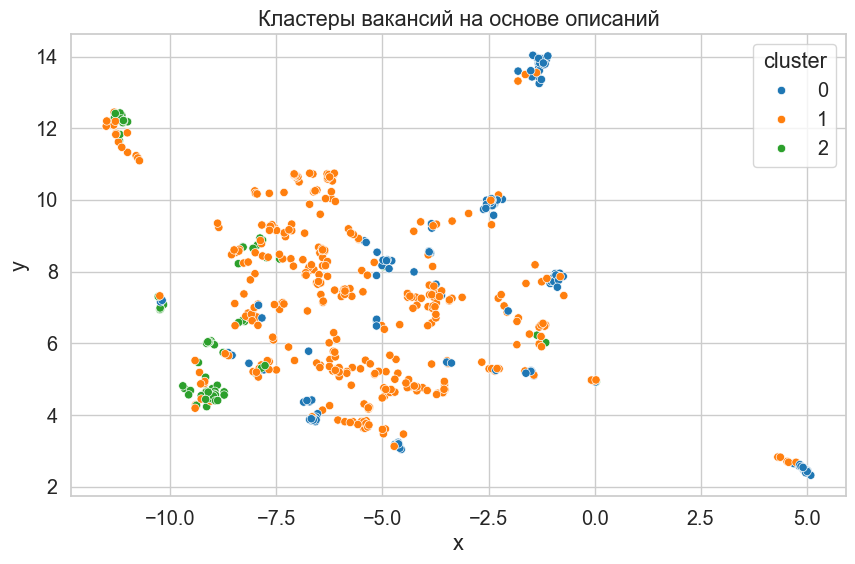

In [39]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
X_embedded = reducer.fit_transform(X.toarray())
df["x"] = X_embedded[:, 0]
df["y"] = X_embedded[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="tab10")
plt.title("Кластеры вакансий на основе описаний")
plt.show()


для интерпритации кластеров, посмотрим какие слова часще всего встречаются в описании

In [40]:
cluster_summary = []

for i in range(n_clusters):
    cluster_texts = df[df["cluster"] == i]["description"]
    words = " ".join(cluster_texts).lower().split()
    freq_words = pd.Series(words).value_counts().head(10).index.tolist()
    cluster_summary.append({
        "Кластер": i,
        "Топ-10 слов": ", ".join(freq_words)
    })

# Преобразуем в DataFrame
df_cluster_keywords = pd.DataFrame(cluster_summary)

# Вывод
df_cluster_keywords


,Кластер,Топ-10 слов
0,0,"., аналитик, аналитик., системный, данных., пр..."
1,1,"., по, /, менеджер, в, и, data, руководитель, ..."
2,2,"., data, scientist, scientist., engineer., /, ..."


мы видим, что при делении на три кластера прослеживаются 2 основных направления связанные с руководством, менджментом и второе - это аналитика и data science. Выделяется еще третья категория, но она связана с анлоязычным описанием этих же кластеров, поэтому не имеет смысла выделять ее как отдельную.